# Animations avec un notebook

## Code supplémentaire

In [1]:
from matplotlib import rc
rc('animation', html='html5')

## Les classes

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation


class MethNumInt:
    def rk2(self, f, t, y0):
        y = np.zeros((len(t), len(y0)))
        k1 = np.zeros(len(y0))
        k2 = np.copy(k1)
        y[0, :] = y0[:]
        for n in range(1, len(t)):
            yprec = y[n-1]
            tprec = t[n-1]
            h = t[n]-tprec
            k1[:] = f(tprec, yprec)
            k2[:] = f(tprec+h, yprec+h*k1)
            y[n, :] = yprec+(h/2)*(k1+k2)
        return t, y

    def rk4(self, f, t, y0):
        y = np.zeros((len(t), len(y0)))
        k1 = np.zeros(len(y0))
        k2 = np.copy(k1)
        k3 = np.copy(k1)
        k4 = np.copy(k1)
        y[0, :] = y0[:]
        for n in range(1, len(t)):
            yprec = y[n-1]
            tprec = t[n-1]
            h = t[n]-tprec
            k1[:] = f(tprec, yprec)
            k2[:] = f(tprec+h/2, yprec+(h/2)*k1)
            k3[:] = f(tprec+h/2, yprec+(h/2)*k2)
            k4[:] = f(tprec+h, yprec+h*k3)
            y[n, :] = yprec+(h/6)*(k1+2*k2+2*k3+k4)
        return t, y


class AnimObj:
    def animate(self, n):
        if n > self._Ndeb:
            self._nt = np.round((n-self._Ndeb)*(self.interval/1000.0)/self.dt)
            _, y = self.methode_int(self.F, np.arange(
                self._nt_prec, self._nt+1)*self.dt, self._yt)
            self._yt = y[-1]
            self._nt_prec = self._nt
        self.graph(self._nt*self.dt, self._yt)
        return self.listegraph

    def anim(self):
        self._N = int(np.fix(1000*(self.T+self.Tdeb)/self.interval))+1
        self._Ndeb = int(np.fix(1000*self.Tdeb/self.interval))
        self._nt = 0
        self._nt_prec = 0
        self._yt = self.y0
        self.init_graph()

        animobj = FuncAnimation(self.fig, self.animate, frames=self._N,
                                interval=self.interval, blit=True, repeat=False)
        return animobj


class PenSim(MethNumInt, AnimObj):
    def __init__(self,
                 l=9.81/(4*np.pi**2), g=9.81,
                 T=20, Tdeb=1, interval=10, dt=0.001, y0=[np.pi/20, 0],
                 meth="rk4"
                 ):
        self.l, self.g = l, g
        self.T, self.Tdeb, self.interval, self.dt, self.y0 =\
            T, Tdeb, interval, dt, y0
        self.methode_int = getattr(self, meth)

    def F(self, t, Y):
        l, g = self.l, self.g
        theta = Y[0]
        thetap = Y[1]
        Yp = np.zeros(len(Y))
        Yp[0] = thetap
        Yp[1] = -(g/l)*np.sin(theta)
        return Yp

    def init_graph(self):
        l, g = self.l, self.g
        self.fig = plt.figure()
        ax = self.fig.add_subplot(111, aspect='equal', autoscale_on=False,
                                  xlim=(-1.2*l, 1.2*l), ylim=(-1.2*l, 1.2*l))
        ax.grid()
        ax.set_title(
            f'l={l:.2f} m, g={g:.2f} m/s^2, période={2*np.pi*np.sqrt(l/g):.2f} s')
        self.listegraph = []
        h, = ax.plot([], [], 'ob-', lw=2)
        self.listegraph.append(h)
        h = ax.text(-l, l, [], backgroundcolor='y', fontweight='bold')
        self.listegraph.append(h)

    def graph(self, t, Y):
        x = [0, self.l*np.sin(Y[0])]
        y = [0, -self.l*np.cos(Y[0])]
        self.listegraph[0].set_data(x, y)
        self.listegraph[1].set_text(f't={t:.2f}')


class PenDbl(MethNumInt, AnimObj):
    def __init__(self,
                 m1=1, m2=1, l1=1, l2=1, g=9.81,
                 T=20, Tdeb=1, interval=10, dt=0.001, y0=[0.75*np.pi, 0.75*np.pi, 0, 0],
                 meth="rk4"
                 ):
        self.m1, self.m2, self.l1, self.l2, self.g = m1, m2, l1, l2, g
        self.T, self.Tdeb, self.interval, self.dt, self.y0 =\
            T, Tdeb, interval, dt, y0
        self.methode_int = getattr(self, meth)

    def F(self, t, Y):
        m1, m2, l1, l2, g = self.m1, self.m2, self.l1, self.l2, self.g
        theta1, theta2, theta1p, theta2p = Y[0], Y[1], Y[2], Y[3]
        Yp = np.zeros(len(Y))
        A = np.array([[l1*np.cos(theta1-theta2), l2],
                     [(m1+m2)*l1, m2*l2*np.cos(theta1-theta2)]])
        B = np.array([[l1*theta1p**2*np.sin(theta1-theta2)-g*np.sin(theta2)],
                      [-l2*m2*theta2p**2*np.sin(theta1-theta2)-(m1+m2)*g*np.sin(theta1)]])
        sol = np.linalg.solve(A, B)
        Yp[0] = theta1p
        Yp[1] = theta2p
        Yp[2] = sol[0, 0]
        Yp[3] = sol[1, 0]
        return Yp

    def init_graph(self):
        m1, m2, l1, l2 = self.m1, self.m2, self.l1, self.l2
        D = l1 + l2
        self.fig = plt.figure()
        ax = self.fig.add_subplot(111, aspect='equal', autoscale_on=False,
                                  xlim=(-1.2*D, 1.2*D), ylim=(-1.2*D, 1.2*D))
        ax.grid()
        ax.set_title(
            f'l1={l1:.2f} m, l2={l2:.2f} m, m1={m1:.2f} kg, m2={m2:.2f} kg')
        self.listegraph = []
        h, = ax.plot([], [], 'bo-', lw=2)
        self.listegraph.append(h)
        h = ax.text(-D, D, [], backgroundcolor='y', fontweight='bold')
        self.listegraph.append(h)

    def graph(self, t, Y):
        theta1, theta2 = Y[0], Y[1]
        l1, l2 = self.l1, self.l2
        x = [0, l1*np.sin(theta1), l1*np.sin(theta1)+l2*np.sin(theta2)]
        y = [0, -l1*np.cos(theta1), -l1*np.cos(theta1)-l2*np.cos(theta2)]
        self.listegraph[0].set_data(x, y)
        self.listegraph[1].set_text(f't={t:.2f}')


class PenCha(MethNumInt, AnimObj):
    def __init__(self,
                 m=0.1, M=0.2, g=9.81, l=0.5,
                 T=20, Tdeb=1, interval=10, dt=0.001, y0=[0, np.pi/10, 0, 0],
                 meth="rk4",
                 tr=2, tcut=9.2,
                 K=np.array(
                     [[-70.71067812, 117.80656658, -41.30227373,  26.21802518]]),
                 G=np.array([-70.71067812])
                 ):
        self.m, self.M, self.g, self.l = m, M, g, l
        self.T, self.Tdeb, self.interval, self.dt, self.y0 =\
            T, Tdeb, interval, dt, y0
        self.methode_int = getattr(self, meth)
        self.tr, self.tcut, self.K, self.G = tr, tcut, K, G

    def F(self, t, Y):
        m, M, g, l = self.m, self.M, self.g, self.l
        theta = Y[1]
        xp = Y[2]
        thetap = Y[3]
        Yp = np.zeros(len(Y))
        u = self.u(t, Y)
        xpp = (u+m*g*np.sin(theta)*np.cos(theta)-m*l*thetap **
               2*np.sin(theta))/(M+m*np.sin(theta)**2)
        thetapp = (xpp*np.cos(theta)+g*np.sin(theta))/l
        Yp[0] = xp
        Yp[1] = thetap
        Yp[2] = xpp
        Yp[3] = thetapp
        return Yp

    def init_graph(self):
        m, M, l, tcut = self.m, self.M, self.l, self.tcut
        self.fig = plt.figure()
        ax = self.fig.add_subplot(111, aspect='equal', autoscale_on=False,
                                  xlim=(-2*l, 2*l), ylim=(-1.2*l, 1.2*l))
        ax.grid()
        ax.set_title(
            f'm={m:.2f} kg, M={M:.2f} kg, l={l:.2f} m, tcut={tcut:.2f} s')
        self.listegraph = []
        h, = ax.plot([], [], 'bo-', lw=2)
        self.listegraph.append(h)
        h, = ax.plot([], [], 'ro-', lw=2)
        self.listegraph.append(h)
        h = ax.text(-l, l, [], backgroundcolor='y', fontweight='bold')
        self.listegraph.append(h)

    def graph(self, t, Y):
        l = self.l
        x = Y[0]
        theta = Y[1]
        self.listegraph[0].set_data(
            [x, x-l*np.sin(theta)], [0, l*np.cos(theta)])
        self.listegraph[1].set_data([-l/2+x, l/2+x], [0, 0])
        self.listegraph[2].set_text(f't={t:.2f}')

    def e(self, t):
        if t <= self.tr:
            return 0
        else:
            return 0.25+0.25*np.sign(np.sin(0.5*np.pi*(t-self.tr)))

    def u(self, t, Y):
        if t <= self.tcut:
            return -self.K@Y+self.G*self.e(t)
        else:
            return 0


class Toupie(MethNumInt, AnimObj):
    def __init__(self,
                 Inertie=np.array([1, 2.8, 3]),
                 Omega0=np.array([0, 2*np.pi, 2*np.pi*0.02]),
                 Q=np.eye(3),
                 T=20, Tdeb=1, interval=10, dt=0.001,
                 meth="rk4"
                 ):
        self.Inertie = Inertie
        self.T, self.Tdeb, self.interval, self.dt, self.y0 =\
            T, Tdeb, interval, dt, np.concatenate([Omega0, np.reshape(Q, 9)])
        self.methode_int = getattr(self, meth)

    def F(self, t, Y):
        Yp = np.zeros(12)
        Inertie = self.Inertie
        I1, I2, I3 = Inertie[0], Inertie[1], Inertie[2]
        O1, O2, O3 = Y[0], Y[1], Y[2]
        Yp[0] = O2*O3*(I2-I3)/I1
        Yp[1] = O3*O1*(I3-I1)/I2
        Yp[2] = O1*O2*(I1-I2)/I3
        OmegaS = [[0, -O3, O2], [O3, 0, -O1],
                  [-O2, O1, 0]]
        Q = np.reshape(Y[3:12], (3, 3))
        Qp = Q@OmegaS
        Yp[3:12] = np.reshape(Qp, 9)
        return Yp

    def init_graph(self):
        self.fig = plt.figure()
        self.listegraph = []
        ax = self.fig.add_subplot(projection='3d')
        hx, = ax.plot([], [], [], 'g', linewidth=2, label='X')
        self.listegraph.append(hx)
        hy, = ax.plot([], [], [], 'r', linewidth=4, label='Y')
        self.listegraph.append(hy)
        hz, = ax.plot([], [], [], 'b', linewidth=2, label='Z')
        self.listegraph.append(hz)
        h0, = ax.plot([], [], [], 'k', linewidth=4, label='ombre')
        self.listegraph.append(h0)
        ht = ax.text(-1, -1, 2, [], backgroundcolor='y', fontweight='bold')
        self.listegraph.append(ht)
        ax.axes.set_xlim3d(left=-1.2, right=1.2)
        ax.axes.set_ylim3d(bottom=-1.2, top=1.2)
        ax.axes.set_zlim3d(bottom=-1, top=1)
        ax.set_xlabel('X'), ax.set_ylabel('Y'), ax.set_zlabel('Z')
        ax.legend()

    def graph(self, t, Y):
        Q = np.reshape(Y[3:12], (3, 3))
        hx = self.listegraph[0]
        hx.set_data_3d([-Q[0, 0]/2, Q[0, 0]/2],
                       [-Q[1, 0]/2, Q[1, 0]/2],
                       [-Q[2, 0]/2, Q[2, 0]/2])
        hy = self.listegraph[1]
        hy.set_data_3d([0, Q[0, 1]/2], [0, Q[1, 1]/2], [0, Q[2, 1]/2])
        hz = self.listegraph[2]
        hz.set_data_3d([-Q[0, 2]/4, Q[0, 2]/4],
                       [-Q[1, 2]/4, Q[1, 2]/4],
                       [-Q[2, 2]/4, Q[2, 2]/4])
        h0 = self.listegraph[3]
        h0.set_data_3d([0, Q[0, 1]/2], [0, Q[1, 1]/2], [-1, -1])
        ht = self.listegraph[4]
        ht.set_text(f't={t:.2f}s')

    def var_moment_cine(self):
        t = np.arange(0,  np.floor(self.T/self.dt)+1)*self.dt
        _, y = self.methode_int(self.F, t, self.y0)

        MomentCinetique = np.zeros((len(t), 3))
        for n in range(0, len(t)):
            Q = np.reshape(y[n, 3:12], (3, 3))
            MomentCinetique[n, :] = (Q@(self.Inertie*y[n, 0:3]).T).T

        M0 = MomentCinetique[0, :]
        plt.figure()
        plt.plot(t, (MomentCinetique[:, 0]-M0[0])/np.linalg.norm(M0),
                 'r', label='$\\dfrac{\\Delta\\sigma_X(t)}{\\|\\overrightarrow\\sigma(0)\\|}$')
        plt.plot(t, (MomentCinetique[:, 1]-M0[1])/np.linalg.norm(M0),
                 'g', label='$\\dfrac{\\Delta\\sigma_Y(t)}{\\|\\overrightarrow\\sigma(0)\\|}$')
        plt.plot(t, (MomentCinetique[:, 2]-M0[2])/np.linalg.norm(M0),
                 'b', label='$\\dfrac{\\Delta\\sigma_Z(t)}{\\|\\overrightarrow\\sigma(0)\\|}$')
        plt.title('Variation du moment cinétique dans le repère fixe')
        plt.xlabel('temps (en s)')
        plt.grid('on')
        plt.legend()

        plt.figure()
        plt.plot(t, y[:, 0:3]/(2*np.pi))
        plt.legend(['$\\Omega_1$', '$\\Omega_2$', '$\\Omega_3$'])
        plt.grid('on')
        plt.xlabel('temps (en s)')
        plt.ylabel('vitesse (en tours/seconde)')
        plt.title(
            f'vitesses initiales (tr/s) : $\\Omega_1$={self.y0[0]/(2*np.pi):.2f},$\\Omega_2$={self.y0[1]/(2*np.pi):.2f},$\\Omega_3$={self.y0[2]/(2*np.pi):.2f}')

        plt.show()


# Ligne RJ45 (V=230000 km/s, Zc = 100 Ohm)
# V : vitesse de propagation en m/s
# Zc : impédance caractéristique en Ohm
# Re : impédance en entrée de la ligne en Ohm
# Rs : impédance en sortie de la ligne en Ohm
# N : nombre de segments élémentaires pour modéliser la ligne
# D : longueur de la ligne en m
# echtps : unité de temps pour l'affichage en s
#          (1e-6 = 1 microseconde correspond à une seconde d'affichage)
# T : durée de la simulation en s
#          (20 = 20 microseconde correspond à 20 secondes d'affichage)
# Tdeb : démarrage de la simulation en s
# interval : période de rafraichissement en ms
# dt : pas de calcul en unité de temps
# meth : méthode d'intégration numérique


class Ligne(MethNumInt, AnimObj):
    def __init__(self,
                 V=2.3e8, Zc=100, Re=0, Rs=0, N=2000, D=500, echtps=1e-6,
                 T=20, Tdeb=1, interval=10, dt=0.001,
                 meth="rk4"
                 ):
        self.V, self.Zc, self.Re, self.Rs, self.N, self.D, self.echtps =\
            V, Zc, Re, Rs, N, D, echtps
        dx = D/N
        C, L = 1/(V*Zc), Zc/V
        self.dx, self.Cdx, self.Ldx = dx, C*dx, L*dx
        self.T, self.Tdeb, self.interval, self.dt, self.y0 =\
            T, Tdeb, interval, dt, np.zeros(2*N+1)
        self.methode_int = getattr(self, meth)

    def F(self, t, Y):
        N, Re, Rs, Cdx, Ldx = self.N, self.Re, self.Rs, self.Cdx, self.Ldx
        Yp = np.zeros(2*N+1)
        U = Y[0:N]
        I = Y[N:2*N+1]
        Yp[0:N] = self.echtps*(1/Cdx)*(I[0:N]-I[1:N+1])
        Yp[N:2*N+1] = self.echtps*(1/Ldx)*np.concatenate(
            ([2*self.e(t)-2*Re*I[0]-2*U[0]], U[0:N-1]-U[1:N], [-2*Rs*I[N]+2*U[N-1]]))
        return Yp

    def init_graph(self):
        self.fig = plt.figure()
        self.listegraph = []
        self.fig.set_size_inches(10, 4)
        ax = self.fig.add_subplot(
            111, autoscale_on=False, xlim=(0, self.D), ylim=(-2, 2))
        ax.set_title(f'$Vdt/dx = {self.V*self.dt*self.echtps/self.dx:f}$')
        ax.grid()
        ax.set_xlabel('distance (en $m$)')
        ax.set_ylabel('amplitude (en $V$)')
        h, = ax.plot([], [])
        self.listegraph.append(h)
        h = ax.text(self.D/10, 1.5, [], backgroundcolor='y', fontweight='bold')
        self.listegraph.append(h)

    def graph(self, t, Y):
        N, dx = self.N, self.dx
        self.listegraph[0].set_data(np.arange(N)*dx, Y[0:N])
        self.listegraph[1].set_text(f'$t={t:.2f} \\mu s$ ')

    def e(self, t):
        Te = 250e-9/self.echtps
        if t < Te:
            src = (1-np.cos(2*np.pi*t/Te))/2
        else:
            src = 0
        return src

## Génération de l'animation

In [3]:
# pensim = PenSim(interval=40, Tdeb=0)
# anim = pensim.anim()
# plt.close()
# pendbl = PenDbl(interval=40, Tdeb=0)
# anim = pendbl.anim()
# plt.close()
# pencha = PenCha(interval=40, Tdeb=0)
# anim = pencha.anim()
# plt.close()
# toupie = Toupie(interval=40, Tdeb=0)
# anim = toupie.anim()
# plt.close()
ligne = Ligne(interval=40, Tdeb=0)
anim = ligne.anim()
plt.close()

In [4]:
anim

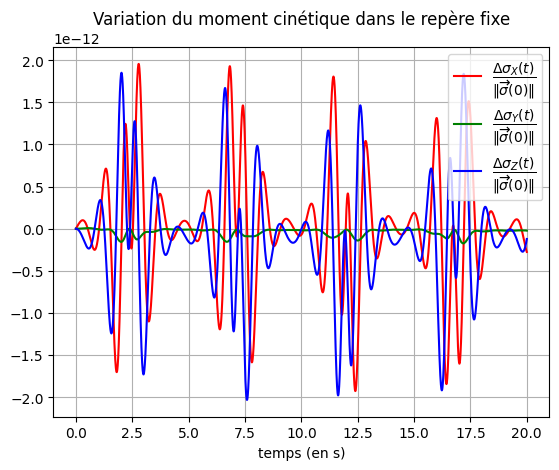

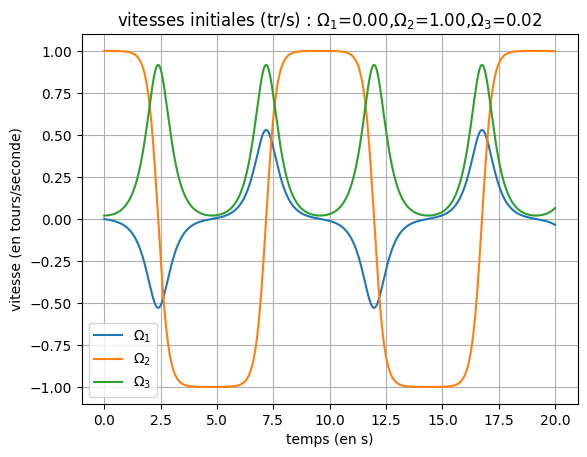

In [5]:
toupie = Toupie()
toupie.var_moment_cine()